# Customer calls prediction

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [7]:
main_df = pd.read_csv('df_flagged_extra.csv')

In [8]:
words_pca = np.load('./corp_reducted.dmp.npy')

In [9]:
words_pca_ex = np.load('./corp_reducted_ex.dmp.npy')

In [11]:
train_X = np.concatenate( (words_pca,
                main_df.no_links.ravel().reshape(len(main_df.no_codeblock), 1),
                main_df.no_links.ravel().reshape(len(main_df.no_images), 1), 
                main_df.no_images.ravel().reshape(len(main_df.no_links), 1)), axis=1)

train_X_ex = np.concatenate( (words_pca_ex,
                main_df.no_links.ravel().reshape(len(main_df.no_codeblock), 1),
                main_df.no_links.ravel().reshape(len(main_df.no_images), 1), 
                main_df.no_images.ravel().reshape(len(main_df.no_links), 1)), axis=1)

In [13]:
shuffleSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=13)
first_split = shuffleSplit.split(train_X, main_df.has_support_case)

train_indx = []
test_indx = []
for train_i, test_i in first_split:
    train_indx = train_i
    test_indx = test_i

In [44]:
def find_best_classifier(clf, scoring_val, search_params, useEx=False, useCombined=False):
    rsearch = RandomizedSearchCV(clf, search_params, scoring=scoring_val, n_jobs=3, n_iter=25)
    if useEx:
        tt_X = train_X_ex
    else:
        tt_X = train_X
    if useCombined:
        if useEx:
            train_collection = X_comb_ex
            train_outcome = y_comb_ex
        else:
            train_collection = X_comb
            train_outcome = y_comb
    else:
        train_collection = tt_X[train_indx, :]
        train_outcome = main_df.has_support_case.ravel()[train_indx]
    rsearch.fit(train_collection, train_outcome)
    print(u"Training score {:.2f}, \n Hyper params: {} \n".format( rsearch.best_score_, rsearch.best_params_) )
    y_test  = rsearch.best_estimator_.predict(tt_X[test_indx, :])
    auc_test = roc_auc_score(main_df.has_support_case.ravel()[test_indx], y_test)
    f1_test = f1_score(main_df.has_support_case.ravel()[test_indx], y_test)
    
    print("Test score: AUC = {:.2f}  F1 = {:.2f}".format(auc_test, f1_test))

## SVM classifier

In [30]:
svc_class = SVC()
svc_class.fit(train_X[train_indx, :], main_df.has_support_case.ravel()[train_indx])
prediction_svc = svc_class.predict(train_X[train_indx, :])
print(u"Train AUC : {:.2f} \nTrain F1: {:.2f}".format(roc_auc_score(main_df.has_support_case.ravel()[train_indx], prediction_svc),
                                                     f1_score(main_df.has_support_case.ravel()[train_indx], prediction_svc)))
prediction_svc = svc_class.predict(train_X[test_indx, :])

print(u"Test AUC : {:.2f} \nTest F1: {:.2f}".format(roc_auc_score(main_df.has_support_case.ravel()[test_indx], prediction_svc),
                                                   f1_score(main_df.has_support_case.ravel()[test_indx], prediction_svc)))

Train AUC : 0.51 
Train F1: 0.03
Test AUC : 0.50 
Test F1: 0.00


/home/kliton/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
parameter_distrib = {"C":np.logspace(-2, 10, num=5),
                    "gamma": np.logspace(-9, 3, num=5)}

find_best_classifier(SVC(), "roc_auc", parameter_distrib)

Training score 0.76, 
 Hyper params: {'gamma': 9.9999999999999995e-07, 'C': 10000000.0} 

Test score: AUC = 0.71  F1 = 0.51


In [27]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    find_best_classifier(SVC(), 'f1', parameter_distrib)

Training score 0.45, 
 Hyper params: {'gamma': 9.9999999999999995e-07, 'C': 10000000.0} 

Test score: AUC = 0.71  F1 = 0.51


## Naive Bayes Classifier

In [33]:
nb_class = MultinomialNB()
nb_class.fit(train_X_ex[train_indx, :], main_df.has_support_case.ravel()[train_indx])
prediction_nb = nb_class.predict(train_X_ex[train_indx, :])
print(u"Train AUC : {:.2f} \nTrain F1: {:.2f}".format(roc_auc_score(main_df.has_support_case.ravel()[train_indx], prediction_nb),
                                                     f1_score(main_df.has_support_case.ravel()[train_indx], prediction_nb)))
prediction_nb = svc_class.predict(train_X_ex[test_indx, :])

print(u"Test AUC : {:.2f} \nTest F1: {:.2f}".format(roc_auc_score(main_df.has_support_case.ravel()[test_indx], prediction_nb),
                                                   f1_score(main_df.has_support_case.ravel()[test_indx], prediction_nb)))

Train AUC : 0.56 
Train F1: 0.28
Test AUC : 0.50 
Test F1: 0.00


/home/kliton/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
find_best_classifier(MultinomialNB(), "roc_auc", {"alpha":np.linspace(0, 10)}, useEx=True)

Training score 0.63, 
 Hyper params: {'alpha': 5.9183673469387754} 

Test score: AUC = 0.60  F1 = 0.33


In [40]:
find_best_classifier(MultinomialNB(), "f1", {"alpha":np.linspace(0, 10)}, useEx=True)

/home/kliton/anaconda3/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kliton/anaconda3/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kliton/anaconda3/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Training score 0.29, 
 Hyper params: {'alpha': 1.0204081632653061} 

Test score: AUC = 0.60  F1 = 0.33


Using SMOTE 

In [34]:
from imblearn.combine import SMOTEENN

In [78]:
sme = SMOTEENN(1.0,random_state=13)
X_comb, y_comb = SMOTE( random_state=True, kind='svm').fit_sample(train_X[train_indx, :], main_df.has_support_case.ravel()[train_indx])

In [59]:
X_comb_ex, y_comb_ex = sme.fit_sample(train_X_ex[train_indx, :], main_df.has_support_case.ravel()[train_indx])

In [79]:
find_best_classifier(SVC(), "roc_auc", parameter_distrib, useCombined=True)

Training score 0.96, 
 Hyper params: {'gamma': 0.001, 'C': 10000.0} 

Test score: AUC = 0.68  F1 = 0.46


In [45]:
find_best_classifier(MultinomialNB(), "roc_auc", {"alpha":np.linspace(0, 10)}, useEx=True, useCombined=True)

/home/kliton/anaconda3/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kliton/anaconda3/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kliton/anaconda3/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Training score 0.63, 
 Hyper params: {'alpha': 0.0} 

Test score: AUC = 0.50  F1 = 0.26


/home/kliton/anaconda3/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [80]:
sum(y_comb), sum(main_df.has_support_case.ravel()[train_indx]), len(y_comb)

(574, 156, 1358)

In [67]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [50]:
X_comb, y_comb = RandomUnderSampler(random_state=13).fit_sample(train_X[train_indx, :], main_df.has_support_case.ravel()[train_indx])
X_comb_ex, y_comb_ex = RandomUnderSampler(random_state=13).fit_sample(train_X_ex[train_indx, :], main_df.has_support_case.ravel()[train_indx])

In [71]:
X_comb, y_comb = RandomOverSampler(random_state=13).fit_sample(train_X[train_indx, :], main_df.has_support_case.ravel()[train_indx])
X_comb_ex, y_comb_ex = RandomOverSampler(random_state=13).fit_sample(train_X_ex[train_indx, :], main_df.has_support_case.ravel()[train_indx])

In [72]:
find_best_classifier(SVC(), "roc_auc", parameter_distrib, useCombined=True)

Training score 1.00, 
 Hyper params: {'gamma': 1.0, 'C': 10.0} 

Test score: AUC = 0.52  F1 = 0.10


In [52]:
find_best_classifier(MultinomialNB(), "roc_auc", {"alpha":np.linspace(0, 10)}, useEx=True, useCombined=True)

/home/kliton/anaconda3/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kliton/anaconda3/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kliton/anaconda3/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Training score 0.61, 
 Hyper params: {'alpha': 0.0} 

Test score: AUC = 0.64  F1 = 0.38


/home/kliton/anaconda3/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [53]:
find_best_classifier(SVC(kernel='linear'), "roc_auc", parameter_distrib, useCombined=True)

Training score 0.71, 
 Hyper params: {'gamma': 1.0000000000000001e-09, 'C': 10.0} 

Test score: AUC = 0.73  F1 = 0.47


In [56]:
find_best_classifier(SVC(kernel='sigmoid'), "roc_auc", parameter_distrib, useEx=True)

Training score 0.78, 
 Hyper params: {'gamma': 9.9999999999999995e-07, 'C': 10000.0} 

Test score: AUC = 0.50  F1 = 0.00


/home/kliton/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Validation Curves

In [81]:
from sklearn.model_selection import validation_curve

In [103]:
train_scores, valid_scores = validation_curve(SVC(), train_X, main_df.has_support_case.ravel(), 'C', np.logspace(-2, 3, num=10), scoring = "roc_auc", n_jobs=3)

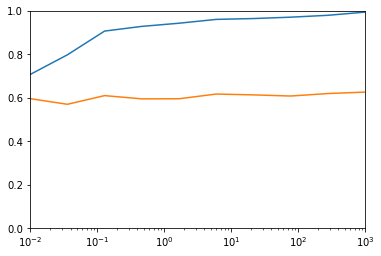

In [114]:
plt.xscale('log')
plt.axis([min(np.logspace(-2, 3, num=2)), max(np.logspace(-2, 3, num=2)), 0, 1])
plt.plot(np.logspace(-2, 3, num=10), np.mean(train_scores, axis=1))
plt.plot(np.logspace(-2, 3, num=10), np.mean(valid_scores, axis=1))
plt.show()

In [115]:
train_scores, valid_scores = validation_curve(SVC(), train_X, main_df.has_support_case.ravel(), 'gamma', parameter_distrib['gamma'], scoring = "roc_auc", n_jobs=3)

In [117]:
train_scores, valid_scores

(array([[ 0.65749235,  0.63936721,  0.61190308],
        [ 0.65478711,  0.67218302,  0.63597977],
        [ 0.95797459,  0.91848977,  0.82695836],
        [ 0.99996471,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ]]),
 array([[ 0.64643613,  0.54537756,  0.64234298],
        [ 0.62799341,  0.59289579,  0.67946366],
        [ 0.64050812,  0.63298048,  0.56645495],
        [ 0.58365091,  0.62262997,  0.62540579],
        [ 0.50764526,  0.50458716,  0.50152905]]))

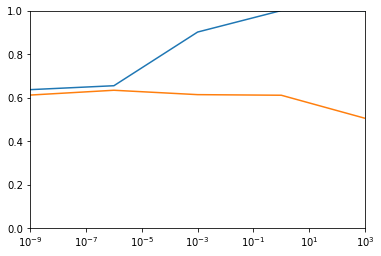

In [116]:
plt.xscale('log')
plt.axis([min(parameter_distrib['gamma']), max(parameter_distrib['gamma']), 0, 1])
plt.plot(parameter_distrib['gamma'], np.mean(train_scores, axis=1))
plt.plot(parameter_distrib['gamma'], np.mean(valid_scores, axis=1))
plt.show()

Gamma value has its optimal value between 10e-07 to 10e-05. Beyond this value we get an overfitted model.

In [138]:
train_scores, valid_scores = validation_curve(SVC(kernel='linear'), train_X, main_df.has_support_case.ravel(), 'C', parameter_distrib['C'], scoring = "roc_auc", n_jobs=3)

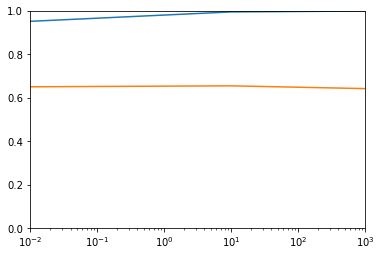

In [140]:
plt.xscale('log')
plt.axis([min(np.logspace(-2, 3, num=2)), max(np.logspace(-2, 3, num=2)), 0, 1])
plt.plot(parameter_distrib['C'], np.mean(train_scores, axis=1))
plt.plot(parameter_distrib['C'], np.mean(valid_scores, axis=1))
plt.show()

In [142]:
train_scores, valid_scores = validation_curve(MultinomialNB(), train_X_ex, main_df.has_support_case.ravel(), 'alpha',  np.linspace(0, 10), scoring = "roc_auc", n_jobs=3)

/home/kliton/anaconda3/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kliton/anaconda3/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kliton/anaconda3/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


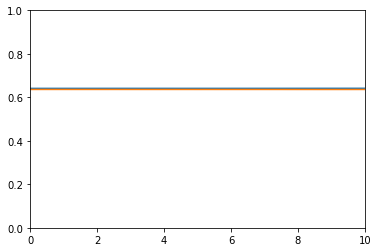

In [144]:
plt.axis([0, 10, 0, 1])
plt.plot(np.linspace(0,10), np.mean(train_scores, axis=1))
plt.plot(np.linspace(0, 10), np.mean(valid_scores, axis=1))
plt.show()

In [145]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [186]:
#X_comb[:, range(0, 100)].shape
1:5 + [10]

SyntaxError: invalid syntax (<ipython-input-186-66e55aff7914>, line 2)

In [189]:
train_scores, valid_scores = validation_curve(RandomForestClassifier(), X_comb[:, [x for x in range(0, 100)] + [562, 563, 564]], y_comb, 'n_estimators',  [10, 50, 100, 10000], scoring = "roc_auc", n_jobs=3)

In [160]:
valid_scores

array([[ 0.87703761,  0.97039177,  0.93920884],
       [ 0.91568265,  0.99141441,  0.99211651],
       [ 0.93321605,  0.99766304,  0.99146456],
       [ 0.94872177,  0.99757277,  0.99394195],
       [ 0.95995348,  0.99903713,  0.99616858]])

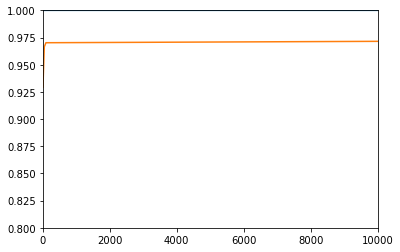

In [190]:
plt.axis([10, 10000, 0.8, 1])
plt.plot([10, 50, 100, 10000], np.mean(train_scores, axis=1))
plt.plot([10, 50, 100, 10000], np.mean(valid_scores, axis=1))
plt.show()

## Learning Curves

In [118]:
from sklearn.model_selection import learning_curve

In [269]:
train_sizes, train_score, test_score = learning_curve(SVC(C=100, gamma=10e-04), train_X[:, [x for x in range(0, 50)] + [562, 563, 564]], main_df.has_support_case.ravel(), cv=StratifiedKFold(shuffle=True), scoring='roc_auc', n_jobs=3)

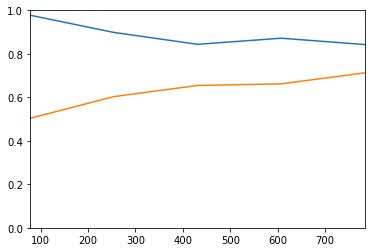

In [270]:
plt.axis([train_sizes[0], train_sizes[-1], 0, 1])
plt.plot(train_sizes, np.mean(train_score, axis=1))
plt.plot(train_sizes, np.mean(test_score, axis=1))
plt.show()

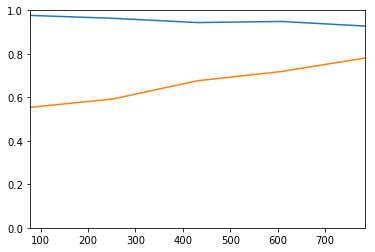

In [236]:
plt.axis([train_sizes[0], train_sizes[-1], 0, 1])
plt.plot(train_sizes, np.mean(train_score, axis=1))
plt.plot(train_sizes, np.mean(test_score, axis=1))
plt.show()

In [271]:
from xgboost import XGBClassifier, plot_importance

In [273]:
train_sizes, train_score, test_score = learning_curve(XGBClassifier(), train_X, main_df.has_support_case.ravel(), cv=StratifiedKFold(shuffle=True), scoring='roc_auc', 
                                                      n_jobs=3)

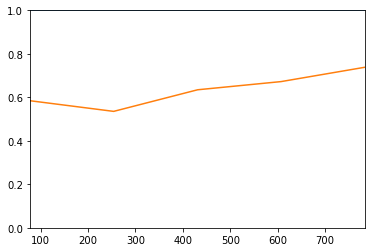

In [276]:
plt.axis([train_sizes[0], train_sizes[-1], 0, 1])
plt.plot(train_sizes, np.mean(train_score, axis=1))
plt.plot(train_sizes, np.mean(test_score, axis=1))
plt.show()

In [280]:
#plot_importance(XGBClassifier().fit(train_X, main_df.has_support_case.ravel()), importance_type="gain", ylim=(534, 564))
xgbc = XGBClassifier().fit(train_X, main_df.has_support_case.ravel())

In [286]:
sorted(zip(range(0, 565), xgbc.feature_importances_), key = lambda x: x[1])

[(3, 0.0),
 (9, 0.0),
 (12, 0.0),
 (14, 0.0),
 (16, 0.0),
 (21, 0.0),
 (23, 0.0),
 (24, 0.0),
 (25, 0.0),
 (30, 0.0),
 (32, 0.0),
 (34, 0.0),
 (35, 0.0),
 (40, 0.0),
 (46, 0.0),
 (47, 0.0),
 (48, 0.0),
 (50, 0.0),
 (51, 0.0),
 (53, 0.0),
 (54, 0.0),
 (56, 0.0),
 (59, 0.0),
 (63, 0.0),
 (67, 0.0),
 (75, 0.0),
 (76, 0.0),
 (77, 0.0),
 (78, 0.0),
 (80, 0.0),
 (81, 0.0),
 (85, 0.0),
 (88, 0.0),
 (91, 0.0),
 (95, 0.0),
 (97, 0.0),
 (99, 0.0),
 (101, 0.0),
 (104, 0.0),
 (105, 0.0),
 (106, 0.0),
 (107, 0.0),
 (111, 0.0),
 (115, 0.0),
 (116, 0.0),
 (117, 0.0),
 (119, 0.0),
 (120, 0.0),
 (121, 0.0),
 (122, 0.0),
 (123, 0.0),
 (132, 0.0),
 (133, 0.0),
 (134, 0.0),
 (137, 0.0),
 (144, 0.0),
 (146, 0.0),
 (148, 0.0),
 (151, 0.0),
 (153, 0.0),
 (155, 0.0),
 (157, 0.0),
 (160, 0.0),
 (161, 0.0),
 (162, 0.0),
 (163, 0.0),
 (165, 0.0),
 (167, 0.0),
 (172, 0.0),
 (173, 0.0),
 (179, 0.0),
 (182, 0.0),
 (188, 0.0),
 (189, 0.0),
 (190, 0.0),
 (191, 0.0),
 (194, 0.0),
 (197, 0.0),
 (198, 0.0),
 (201, 0.0),

In [285]:
len(xgbc.feature_importances_)

565